## Global Black Box Optimization with RNNS

In [91]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

1.1.0


In [92]:
def poly(a,b,c,x):
    return (x-b)**2+c*tf.sin(a*x)

def poly_np(a,b,c,x):
    return (x-b)**2+c*np.sin(a*x)

def min_poly(a,b,c):
    return b, c

In [128]:
def gen_data(n_train, n_test):
    a_train = np.random.uniform(size=(n_train,1),low = 1.0, high = 1.0)
    b_train = np.random.uniform(size=(n_train,1),low = -10.0, high = 10.0)
    c_train = np.random.uniform(size=(n_train,1),low = 3.0, high = 8.0)
    
    a_test = np.random.uniform(size=(n_test,1),low = 1.0, high = 1.0)
    b_test = np.random.uniform(size=(n_test,1),low = -3.0, high = 3.0)
    c_test = np.random.uniform(size=(n_test,1),low = 3.0, high = 8.0)
    
    return (a_train, b_train, c_train, a_test, b_test, c_test)

In [129]:
# Number of Traing/Test examples
n_train = 100
n_test = 100

# Number of hidden states in RNN cell
n_hidden = 10

# Sequence length
num_steps = 10

# Generate Training Data
a_train, b_train, c_train, a_test, b_test, c_test = gen_data(n_train, n_test)

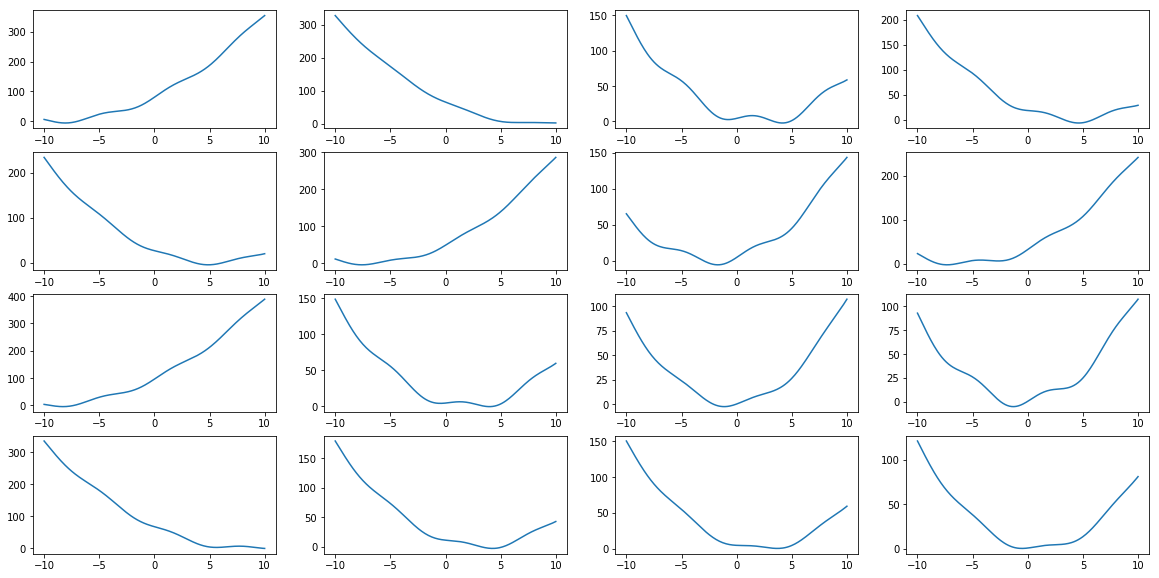

In [130]:
# visualize training data
plt.figure(figsize=(20,10))
for i in range(16):
    xx = np.linspace(-10,10,200)
    yy = poly_np(a_train[i], b_train[i], c_train[i],xx)
    plt.subplot(4,4,1+i)
    plt.plot(xx,yy)
plt.show()

In [131]:
# Create RNN Cell
# x, h = RNN(x, y, h)

variable_dict = {"W1": tf.Variable(tf.truncated_normal([1 + 1 + n_hidden, 30],stddev=0.05)),\
                  "b1": tf.Variable(tf.zeros([30])),\
                  "W2": tf.Variable(tf.truncated_normal([30, 1 + n_hidden],stddev=0.05)),\
                  "b2": tf.Variable(tf.zeros([1 + n_hidden]))}


def rnn_cell(x, y, h, v_dict):
    z = tf.matmul(tf.nn.tanh(tf.matmul(tf.concat([x, y, h], 1),\
                                       v_dict["W1"]) + v_dict["b1"]), v_dict["W2"]) + v_dict["b2"]
        
    return tf.split(z,[1, n_hidden],axis=1)

In [166]:
# Create Model

size = tf.placeholder(tf.int32,[])

a = tf.placeholder(tf.float32, [None, 1])
b = tf.placeholder(tf.float32, [None, 1])
c = tf.placeholder(tf.float32, [None, 1])

x_0 = -2.0*tf.ones([size, 1])
h_0 = tf.truncated_normal([size, n_hidden],stddev=0.1)

h = h_0
x = x_0
y = poly(a,b,c,x)
sample_points = [x]
loss = 0
f_min = y
x_old = x
for i in range(num_steps):
    
    x, h = rnn_cell(x, y, h, variable_dict)
    sample_points.append(x)
    y = poly(a,b,c,x)
    
    dist = -3*tf.abs(x_old-x)
    loss += tf.reduce_mean(y-f_min+dist)/num_steps
    f_min = tf.minimum(y, f_min)
    x_old = x
    

In [167]:
train_rate = tf.placeholder(tf.float32,[])
#train_step = tf.train.AdamOptimizer(train_rate).minimize(f_sum)
train_step = tf.train.AdagradOptimizer(0.1).minimize(loss)
#train_step = tf.train.GradientDescentOptimizer(1.0).minimize(f_out)

[<tf.Tensor 'gradients_10/split_100_grad/concat:0' shape=(?, 11) dtype=float32>, None, None]
[<tf.Tensor 'gradients_10/split_99_grad/concat:0' shape=(?, 11) dtype=float32>, None, None]
[<tf.Tensor 'gradients_10/split_98_grad/concat:0' shape=(?, 11) dtype=float32>, None, None]
[<tf.Tensor 'gradients_10/split_97_grad/concat:0' shape=(?, 11) dtype=float32>, None, None]
[<tf.Tensor 'gradients_10/split_96_grad/concat:0' shape=(?, 11) dtype=float32>, None, None]
[<tf.Tensor 'gradients_10/split_95_grad/concat:0' shape=(?, 11) dtype=float32>, None, None]
[<tf.Tensor 'gradients_10/split_94_grad/concat:0' shape=(?, 11) dtype=float32>, None, None]
[<tf.Tensor 'gradients_10/split_93_grad/concat:0' shape=(?, 11) dtype=float32>, None, None]
[<tf.Tensor 'gradients_10/split_92_grad/concat:0' shape=(?, 11) dtype=float32>, None, None]
[<tf.Tensor 'gradients_10/split_91_grad/concat:0' shape=(?, 11) dtype=float32>, None, None]


In [213]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [215]:
# Train the Network
train_loss_list = []
test_loss_list = []

epochs = 1000
batch_size = 10

for ep in range(epochs):
    for batch in range(n_train//batch_size):
        a_batch = a_train[batch*batch_size:(batch+1)*batch_size]
        b_batch = b_train[batch*batch_size:(batch+1)*batch_size]
        c_batch = c_train[batch*batch_size:(batch+1)*batch_size]
        
        sess.run([train_step], feed_dict={a: a_batch, b: b_batch, c: c_batch, train_rate:0.001, size: batch_size})
    
    train_loss_list += [sess.run([loss], feed_dict={a: a_train, b: b_train, c: c_train, size : n_train})]
    test_loss_list += [sess.run([loss], feed_dict={a: a_test, b: b_test, c: c_test, size:n_test})]
    
    if ep % 100 == 0 or ep == epochs-1:
        print("Epoch: " +str(ep)+" Training loss: "+str(train_loss_list[-1])+ " Test loss: "+str(test_loss_list[-1]))
    
# Extract Samples
samples_train = sess.run([sample_points], feed_dict={a: a_train, b: b_train, c: c_train, size: n_train})
samples_train = np.array(samples_train[0]).reshape(num_steps+1,n_train).T
samples_test = sess.run([sample_points], feed_dict={a: a_test, b: b_test, c: c_test, size: n_test})
samples_test = np.array(samples_test[0]).reshape(num_steps+1,n_test).T

Epoch: 0 Training loss: [-0.19193599] Test loss: [-8.7810898]
Epoch: 100 Training loss: [-2.2440898] Test loss: [-7.2373395]
Epoch: 200 Training loss: [-4.4907341] Test loss: [-7.9954672]
Epoch: 300 Training loss: [-5.1113648] Test loss: [-8.1879644]
Epoch: 400 Training loss: [-5.9027872] Test loss: [-8.6606102]
Epoch: 500 Training loss: [-6.2483711] Test loss: [-8.8701239]
Epoch: 600 Training loss: [-6.5506592] Test loss: [-8.9473639]
Epoch: 700 Training loss: [-6.8494616] Test loss: [-9.2081566]
Epoch: 800 Training loss: [-6.9696712] Test loss: [-9.0325222]
Epoch: 900 Training loss: [-5.9745879] Test loss: [-8.8691187]
Epoch: 999 Training loss: [-7.3141351] Test loss: [-8.7898712]


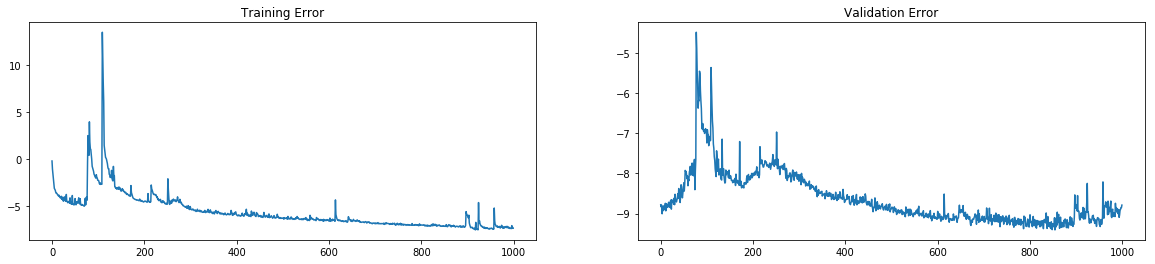

In [216]:
plt.figure(figsize=(20,4))
plt.subplot(1,2,1)
plt.plot(train_loss_list)
plt.title("Training Error")
plt.subplot(1,2,2)
plt.plot(test_loss_list)
plt.title("Validation Error")
plt.show()

In [226]:
def plot_result(traintest="train"): 
    if traintest == "train":
        a, b ,c = (a_train, b_train, c_train)
        samples = samples_train
        i = np.random.randint(n_train)
    else:
        a, b ,c = (a_test, b_test, c_test)
        samples = samples_test
        i = np.random.randint(n_test)
        
    annotation = list(range(num_steps+1))
    xx = np.linspace(-15,15,200)
    yy = poly_np(a[i],b[i],c[i],xx)

    samples_x = samples[i]
    samples_y = poly_np(a[i],b[i],c[i],samples_x)
    
    x_min, y_min = min_poly(a[i],b[i],c[i])

    fig, ax = plt.subplots(figsize=(20,10))
    ax.plot(xx,yy,linewidth=3)
    ax.scatter(samples_x,samples_y)
    #ax.scatter(x_min, y_min, marker='x', linewidth = 30)
    for i, txt in enumerate(annotation):
        ax.annotate(str(txt), (samples_x[i],samples_y[i]),\
                    xytext=(samples_x[i]+np.random.uniform(-1,1),\
                            samples_y[i]+3.0), arrowprops=dict(facecolor='black', shrink=0.01))
    plt.show()
    print(samples_x)
    print(x_min)
    
def plot_multiple(traintest="train"):
    if traintest == "train":
        a, b ,c = (a_train, b_train, c_train)
        title_str = "Training Data"
        samples = samples_train
    else:
        a, b ,c = (a_test, b_test, c_test)
        title_str = "Test Data"
        samples = samples_test
      
    xx = np.linspace(-15,15,200)
    
    plt.figure(figsize=(20,10))
    for i in range(1,9+1):
        samples_x = samples[i]
        samples_y = poly_np(a[i],b[i],c[i],samples_x)
        yy = poly_np(a[i],b[i],c[i],xx)
        plt.subplot(3,3,i)
        plt.plot(xx,yy,linewidth=3)
        plt.scatter(samples_x,samples_y,color='k')
        
    plt.suptitle(title_str)
    plt.show()

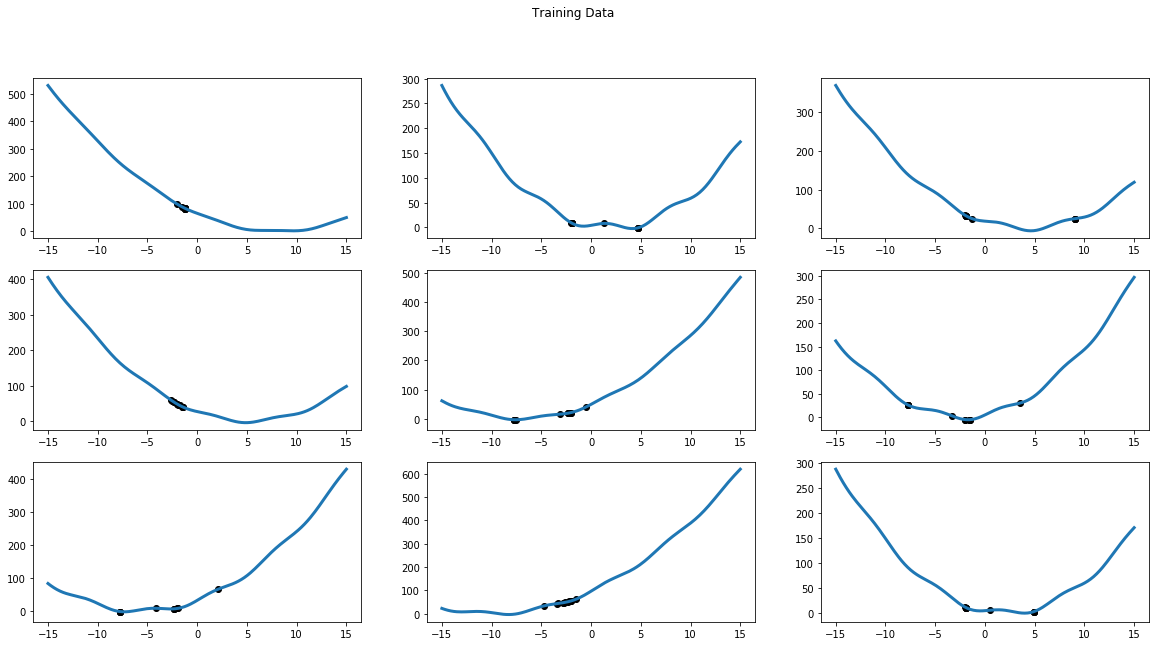

In [227]:
plot_multiple("train")

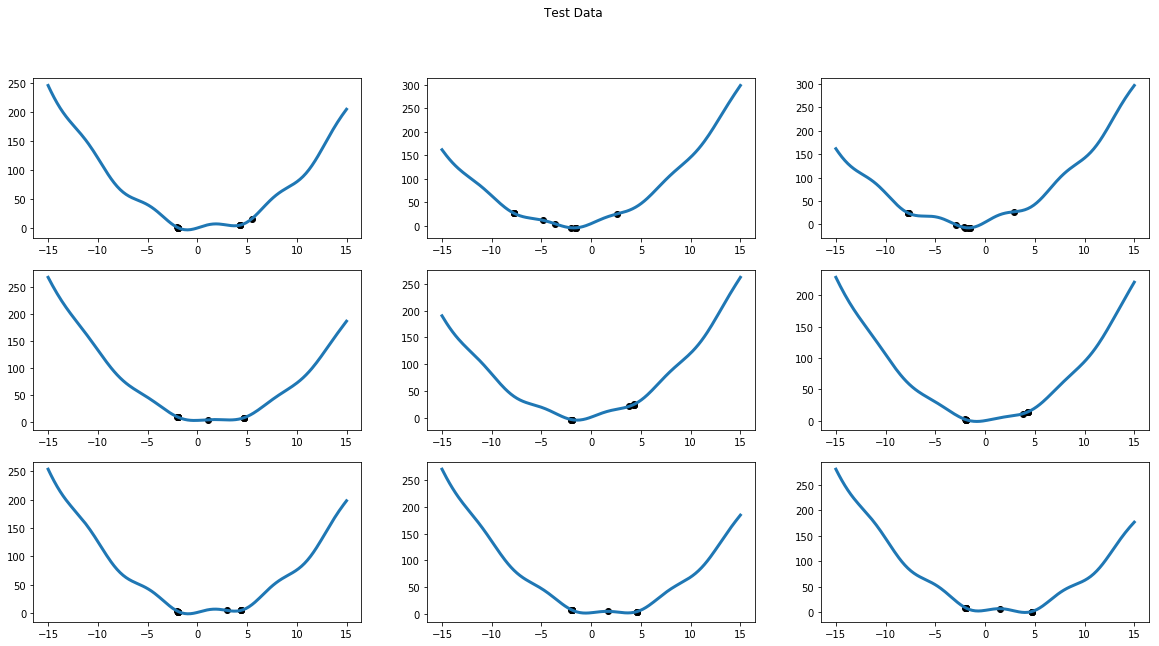

In [228]:
plot_multiple("test")